## Encoder and Decoder


### Encoder
$h_i = g(x_i)$, g is encoder, h is latent feature representation

### Decoder
$x_i = f(h_i)$, f is decoder, h is latent feature representation

Autoencoder Training:

$
arg min <[\Delta(x_i, f(g(x_i)))]
$

But, model can learn identity function, since we want output to look like input. That would be worthless. Hence, the need of **bottleneck and regularization**.

### Regularization in Autoencoders
- to enforce sparsity in the latent feature output.
- l1 or l2 regularization
- 
$
arg min <[\Delta(x_i, f(g(x_i)))] + \lambda \sum_i \theta_i^2
$

### Feed forward Autoencoders
- has an odd number of layers and is symmetrical with respect to the middle layer.
- input layer has n1=n(size of input observation $x_i$)
- middle layer has smallest number of neurons
    - smaller than input, hence the term **bottleneck**.

**All the layers upto the middle one(bottleneck), including the bottleneck, make what is called the encoder**

### Activation Functions in the output layer

#### 1. ReLU
- if input $x_i$ has negative values, then it is a terrible choice.
#### 2. Sigmoid
- if $x_i$ has the range of [0,1] or can be normalized to be within these ranges.

### Loss Functions 
Autoencoder is trying to solve a regression problem.
#### 1. MSE
- find minimum loss, i.e. output~input!
#### 2. BCE
- if output layer has sigmoid function, or input($x_i$) are normalized between 0 and 1.

#### 3. Reconstruction Loss
- represents how good(or bad) the autoencoder is able to reconstruct the input observation $x_i$.
- often used while doing anomaly detection with autoencoders.

In [1]:
import read_dataset

In [2]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 

In [3]:
train_data = read_dataset.DHCDataset()
test_data =  read_dataset.DHCDataset(train=False)
type(train_data)

read_dataset.DHCDataset

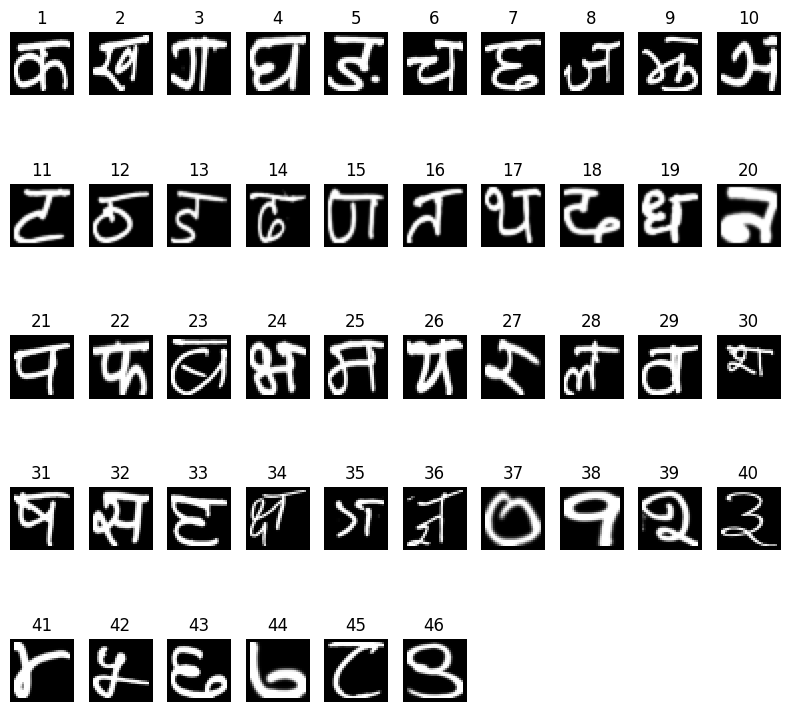

In [4]:
# converting from label to images 
label_to_image = {} 

for image, label in train_data: 
    if label.item() not in label_to_image: 
        label_to_image[label.item()] = image  

sorted_labels = sorted(label_to_image.items()) 

num_labels = len(sorted_labels)
cols = 10
rows = (num_labels + cols - 1) // cols  

plt.figure(figsize=(8, 8))  
for index, (label, image) in enumerate(sorted_labels):
    ax = plt.subplot(rows, cols, index + 1)
    ax.set_title(label)
    ax.imshow(image, cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [5]:
# for devnagari digits, labels range from 37(0) to 46(9) 
# choosing the images with those labels for the training 
train_devnagari = [t for t in train_data if t[1] in range(37, 47)]
test_devnagari = [t for t in test_data if t[1] in range(37, 47)]
len(train_devnagari), len(test_devnagari) 

(17000, 3000)

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list) 

    def __getitem__(self, idx): 
        data_arr, label = self.data_list[idx] 
        data_tensor = torch.tensor(data_arr, dtype=torch.float32) 
        label_tensor = torch.tensor(label-37, dtype=torch.long) 
        return data_tensor, label_tensor

train_dataset = CustomDataset(train_devnagari) 
test_dataset = CustomDataset(test_devnagari) 
train_dataset[0][0].shape, test_dataset[0][1]

C:\Users\OMEN\AppData\Local\Temp\ipykernel_2716\2725063024.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_tensor = torch.tensor(label-37, dtype=torch.long)


(torch.Size([32, 32]), tensor(2))

C:\Users\OMEN\AppData\Local\Temp\ipykernel_2716\2725063024.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_tensor = torch.tensor(label-37, dtype=torch.long)


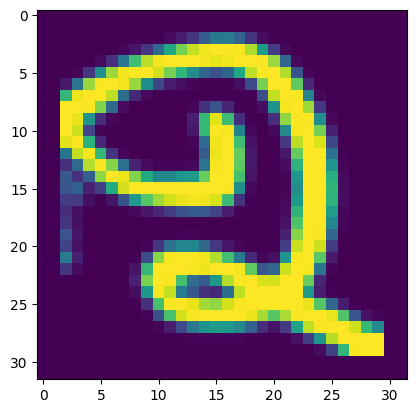

In [7]:
plt.imshow(train_dataset[0][0])

In [8]:
2048*3

6144

In [9]:
batch_size = 2048

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True )

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1fb493e87d0>,
 <torch.utils.data.dataloader.DataLoader at 0x1fb47087390>)

In [10]:
32*32

1024

In [11]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(1024, 12),
            nn.ReLU(0.2),
            nn.Linear(12,1024),
            nn.ReLU(0.2)
        )

    def forward(self, x):
        x = self.model(x)
        return x

model = AutoEncoder()


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
device

'cuda'

In [13]:
%%time

num_epochs = 200
lr=0.001

loss = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr * 0.3)
epoch_losses = []
iter_losses = []

for epoch in range(num_epochs):
    i=0
    for image, label in train_dataloader:
        image = image.to(device)
        label = label.to(device)
        image = torch.squeeze(image, dim=1) 
        image = image.reshape(-1,1024)

        result = model(image)
        optimizer.zero_grad()
        iter_loss = loss(image, result)
        iter_losses.append(iter_loss.cpu().detach().numpy())
        iter_loss.backward()
        optimizer.step()

    if epoch%2==0 and epoch>1:
        print(epoch, "loss=", iter_losses[-1])
        
    

C:\Users\OMEN\AppData\Local\Temp\ipykernel_2716\2725063024.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_tensor = torch.tensor(label-37, dtype=torch.long)


2 loss= 11736.704
4 loss= 11435.992
6 loss= 10956.493
8 loss= 10831.152
10 loss= 10357.063
12 loss= 10191.604
14 loss= 9920.051
16 loss= 9593.255
18 loss= 9397.531
20 loss= 9241.29
22 loss= 9120.463
24 loss= 9219.564
26 loss= 8858.334
28 loss= 8937.427
30 loss= 9026.706
32 loss= 8913.059
34 loss= 8897.846
36 loss= 8896.0
38 loss= 8805.554
40 loss= 8737.078
42 loss= 8573.917
44 loss= 8613.918
46 loss= 8426.161
48 loss= 8494.412
50 loss= 8365.882
52 loss= 8219.069
54 loss= 8237.98
56 loss= 8170.864
58 loss= 8013.7754
60 loss= 8010.333
62 loss= 7834.902
64 loss= 7845.435
66 loss= 7676.69
68 loss= 7644.1494
70 loss= 7594.8086
72 loss= 7430.1543
74 loss= 7316.8433
76 loss= 7233.4365
78 loss= 7139.0923
80 loss= 7288.229
82 loss= 6995.393
84 loss= 6915.5107
86 loss= 7012.511
88 loss= 6903.0796
90 loss= 6787.5723
92 loss= 6790.1807
94 loss= 6757.1914
96 loss= 6585.3516
98 loss= 6643.613
100 loss= 6653.083
102 loss= 6539.963
104 loss= 6473.094
106 loss= 6449.3643
108 loss= 6462.9136
110 loss= 6

without num_workers, bs=512 = 2min 5 sec

without num_workers, bs=2048 = 1min 38 sec


In [14]:
32*32

1024

C:\Users\OMEN\AppData\Local\Temp\ipykernel_2716\2725063024.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_tensor = torch.tensor(label-37, dtype=torch.long)


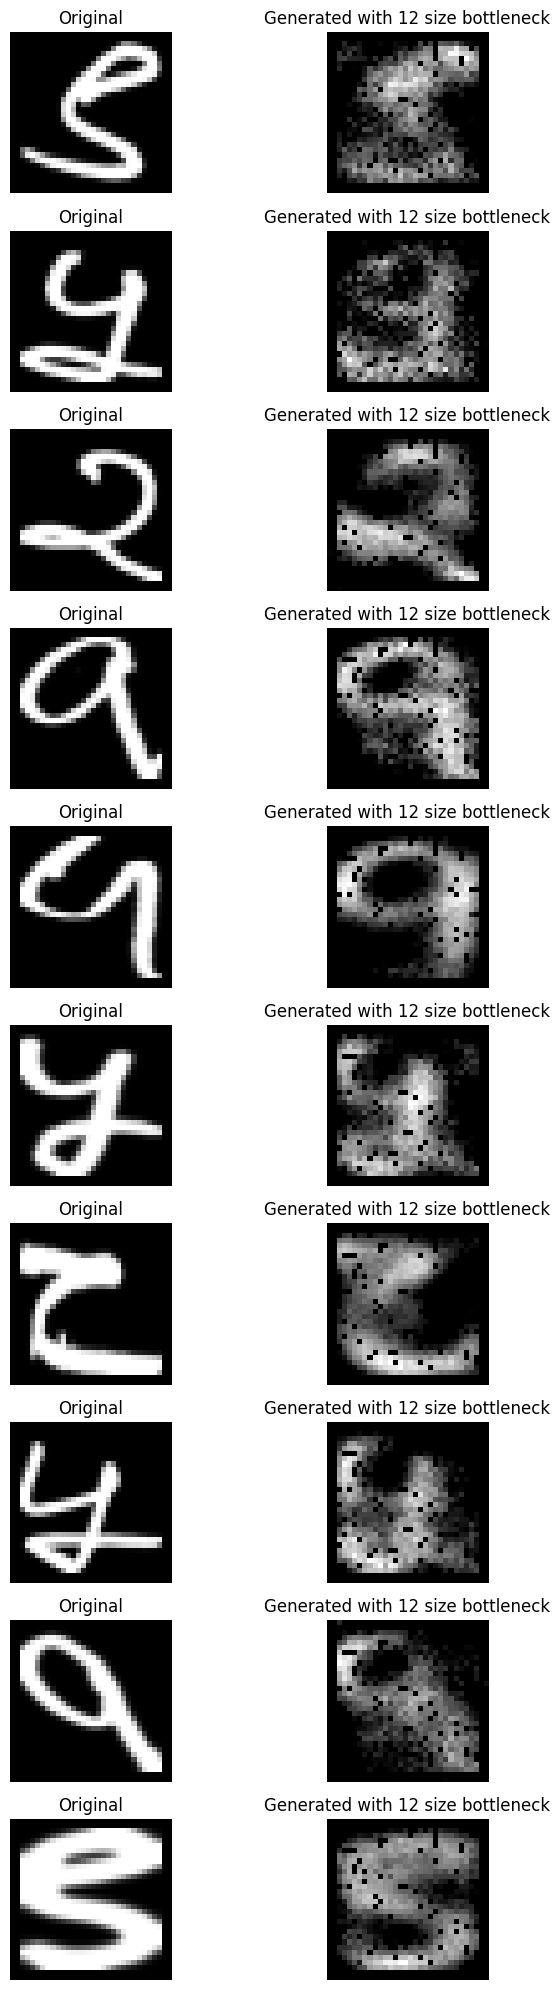

In [15]:
import torch
import matplotlib.pyplot as plt

# Number of images to display
num_images = 10

# Initialize lists to store original and generated images
original_images = []
generated_images = []

# Iterate through the test dataloader
for image, label in test_dataloader:
    image = image.to(device)

    # Process each image in the batch until we have 10 images
    for i in range(image.shape[0]):
        if len(original_images) >= num_images:
            break
        
        # Extract the current image
        original_image = image[i]  # Shape: (1, 32, 32)
        original_image = torch.squeeze(original_image, dim=0)  # Shape: (32, 32)

        # Flatten the original image to match the model input shape
        flattened_image = original_image.reshape(-1, 1024)

        # Pass the flattened image through the model
        generated_image = model(flattened_image)  # Output shape: (784,)

        # Reshape the generated image to 32x32 for visualization
        generated_images.append(generated_image.reshape(32, 32).detach().cpu())
        original_images.append(original_image.detach().cpu())

    if len(original_images) >= num_images:
        break

# Create a 10x2 grid for displaying images
fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 2))
plt.title("With Bottleneck the shape of 12")

for idx in range(num_images):
    # Display the original image in the left column
    axes[idx, 0].imshow(original_images[idx], cmap='gray')
    axes[idx, 0].axis('off')
    axes[idx, 0].set_title("Original")

    # Display the generated image in the right column
    axes[idx, 1].imshow(generated_images[idx], cmap='gray')
    axes[idx, 1].axis('off')
    axes[idx, 1].set_title("Generated with 12 size bottleneck")

plt.tight_layout()
plt.show()


C:\Users\OMEN\AppData\Local\Temp\ipykernel_4372\2725063024.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_tensor = torch.tensor(label-37, dtype=torch.long)


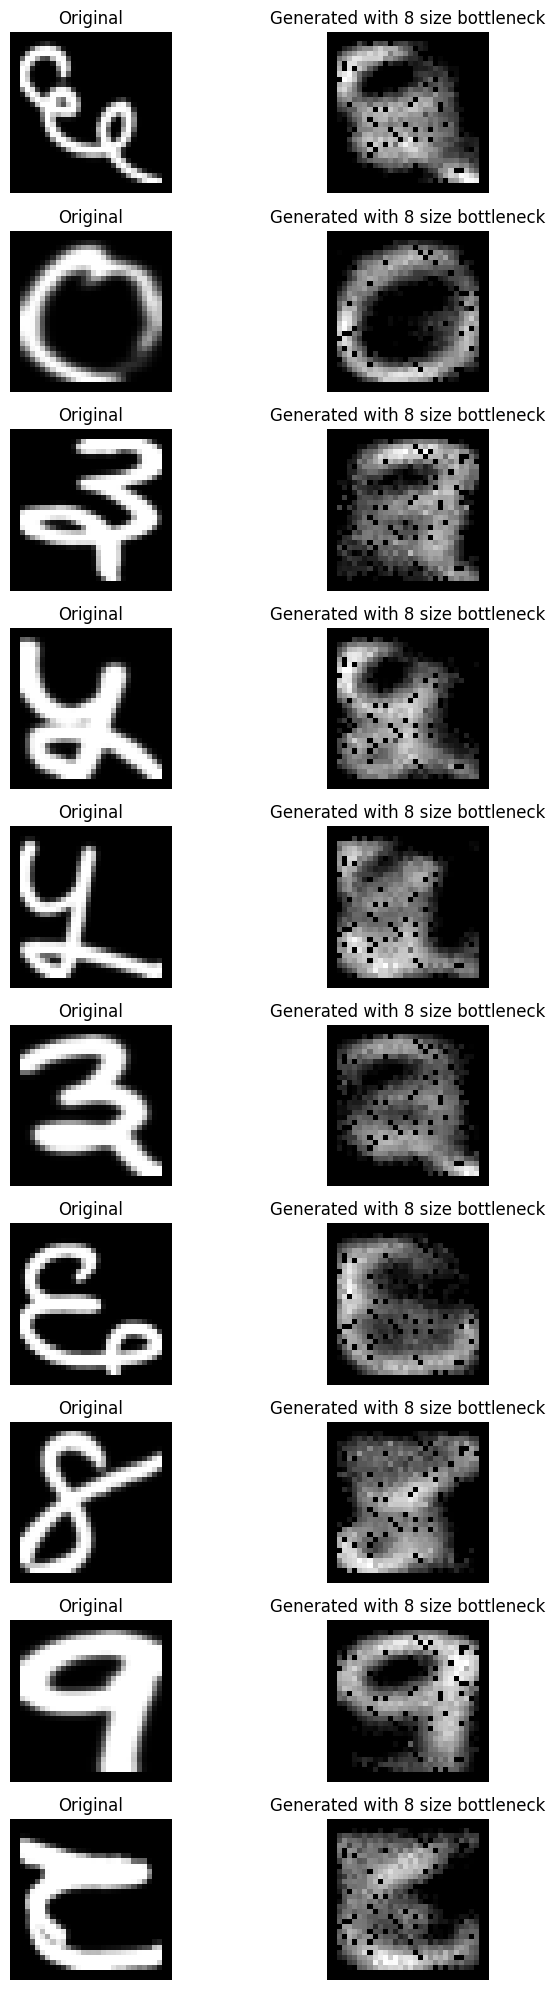

In [26]:
import torch
import matplotlib.pyplot as plt

# Number of images to display
num_images = 10

# Initialize lists to store original and generated images
original_images = []
generated_images = []

# Iterate through the test dataloader
for image, label in test_dataloader:
    image = image.to(device)

    # Process each image in the batch until we have 10 images
    for i in range(image.shape[0]):
        if len(original_images) >= num_images:
            break
        
        # Extract the current image
        original_image = image[i]  # Shape: (1, 32, 32)
        original_image = torch.squeeze(original_image, dim=0)  # Shape: (32, 32)

        # Flatten the original image to match the model input shape
        flattened_image = original_image.reshape(-1, 1024)

        # Pass the flattened image through the model
        generated_image = model(flattened_image)  # Output shape: (784,)

        # Reshape the generated image to 32x32 for visualization
        generated_images.append(generated_image.reshape(32, 32).detach().cpu())
        original_images.append(original_image.detach().cpu())

    if len(original_images) >= num_images:
        break

# Create a 10x2 grid for displaying images
fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 2))
plt.title("With Bottleneck the shape of 64")

for idx in range(num_images):
    # Display the original image in the left column
    axes[idx, 0].imshow(original_images[idx], cmap='gray')
    axes[idx, 0].axis('off')
    axes[idx, 0].set_title("Original")

    # Display the generated image in the right column
    axes[idx, 1].imshow(generated_images[idx], cmap='gray')
    axes[idx, 1].axis('off')
    axes[idx, 1].set_title("Generated with 8 size bottleneck")

plt.tight_layout()
plt.show()


C:\Users\OMEN\AppData\Local\Temp\ipykernel_23188\2725063024.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_tensor = torch.tensor(label-37, dtype=torch.long)


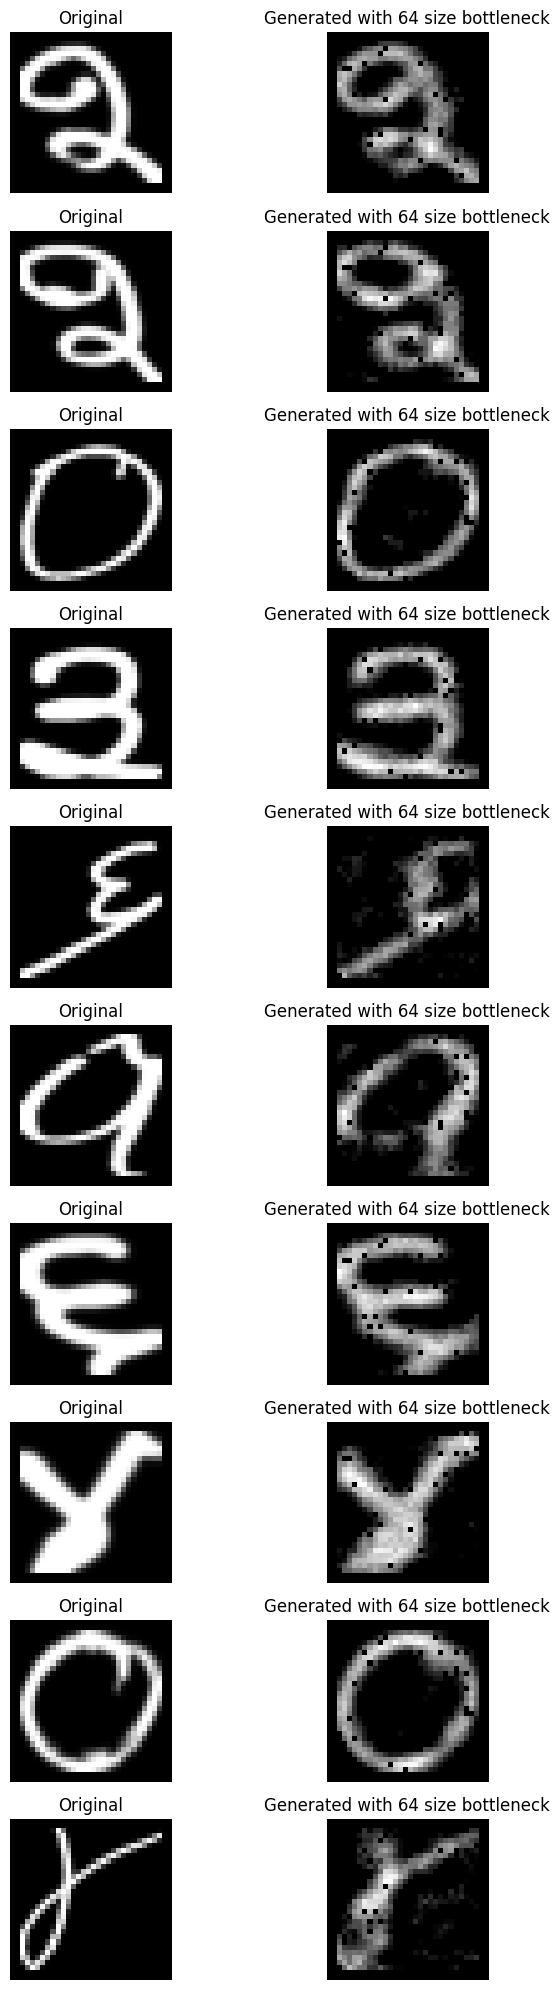

In [34]:
import torch
import matplotlib.pyplot as plt

# Number of images to display
num_images = 10

# Initialize lists to store original and generated images
original_images = []
generated_images = []

# Iterate through the test dataloader
for image, label in test_dataloader:
    image = image.to(device)

    # Process each image in the batch until we have 10 images
    for i in range(image.shape[0]):
        if len(original_images) >= num_images:
            break
        
        # Extract the current image
        original_image = image[i]  # Shape: (1, 32, 32)
        original_image = torch.squeeze(original_image, dim=0)  # Shape: (32, 32)

        # Flatten the original image to match the model input shape
        flattened_image = original_image.reshape(-1, 1024)

        # Pass the flattened image through the model
        generated_image = model(flattened_image)  # Output shape: (784,)

        # Reshape the generated image to 32x32 for visualization
        generated_images.append(generated_image.reshape(32, 32).detach().cpu())
        original_images.append(original_image.detach().cpu())

    if len(original_images) >= num_images:
        break

# Create a 10x2 grid for displaying images
fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 2))
plt.title("With Bottleneck the shape of 64")

for idx in range(num_images):
    # Display the original image in the left column
    axes[idx, 0].imshow(original_images[idx], cmap='gray')
    axes[idx, 0].axis('off')
    axes[idx, 0].set_title("Original")

    # Display the generated image in the right column
    axes[idx, 1].imshow(generated_images[idx], cmap='gray')
    axes[idx, 1].axis('off')
    axes[idx, 1].set_title("Generated with 64 size bottleneck")

plt.tight_layout()
plt.show()
